In [1]:

# 🧩 Deepfake Video Detection using CNN

# Block 1: Imports and Parameters

import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Parameters
video_dir = "uadfv-new"           # Folder with 'real' and 'fake' subfolders
cache_dir = "preprocessed_data"   # Folder to store cached dataset
IMG_SIZE = 128                    # Image size for CNN input
FRAME_SKIP = 5                    # Take every 5th frame


c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:

# Block 2: Dataset Loading, Preprocessing & Caching

def preprocess_frame(frame, face_detector):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face = frame[y:y+h, x:x+w]
    else:
        h, w, _ = frame.shape
        startx = w // 4
        starty = h // 4
        face = frame[starty:starty + h // 2, startx:startx + w // 2]

    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    face = cv2.GaussianBlur(face, (3, 3), 0)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = face / 255.0

    hsv = cv2.cvtColor((face * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    face = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) / 255.0

    return face


def load_images(video_dir, cache_dir="preprocessed_data"):
    os.makedirs(cache_dir, exist_ok=True)
    cache_path = os.path.join(cache_dir, "deepfake_data.npz")

    if os.path.exists(cache_path):
        print("⚡ Loading preprocessed dataset from cache...")
        data = np.load(cache_path)
        return data["X"], data["y"]

    X, y = [], []
    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    for category in ["real", "fake"]:
        cat_dir = os.path.join(video_dir, category)
        label = 0 if category == "real" else 1
        video_files = os.listdir(cat_dir)

        print(f"\n📂 Loading '{category}' videos ({len(video_files)} files)...")
        for video_file in tqdm(video_files, desc=f"Processing {category}", unit="video"):
            video_path = os.path.join(cat_dir, video_file)
            cap = cv2.VideoCapture(video_path)
            count = 0

            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if count % FRAME_SKIP == 0:
                    processed = preprocess_frame(frame, face_detector)
                    X.append(processed)
                    y.append(label)
                count += 1
            cap.release()

    X, y = np.array(X), np.array(y)
    np.savez_compressed(cache_path, X=X, y=y)
    print(f"\n💾 Preprocessed dataset cached at: {cache_path}")
    return X, y


X, y = load_images(video_dir, cache_dir)
print("\n✅ Dataset ready!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Real samples:", np.sum(y == 0))
print("Fake samples:", np.sum(y == 1))



📂 Loading 'real' videos (49 files)...


Processing real: 100%|██████████| 49/49 [00:41<00:00,  1.19video/s]



📂 Loading 'fake' videos (49 files)...


Processing fake: 100%|██████████| 49/49 [00:38<00:00,  1.27video/s]



💾 Preprocessed dataset cached at: preprocessed_data\deepfake_data.npz

✅ Dataset ready!
X shape: (6899, 128, 128, 3)
y shape: (6899,)
Real samples: 3483
Fake samples: 3416


In [3]:

# Block 3: Train-Test Split & Data Augmentation

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (5519, 128, 128, 3)
Testing set: (1380, 128, 128, 3)


In [4]:

# Block 4: CNN Model Creation

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(0.0003), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,241,025 (19.99 MB)

 Trainable params: 5,240,065 (19.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [5]:

# Block 5: Model Training

early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=80,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 57s 300ms/step - accuracy: 0.8040 - loss: 0.5266 - val_accuracy: 0.4949 - val_loss: 2.6756 - learning_rate: 3.0000e-04
Epoch 2/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.9098 - loss: 0.2367 - val_accuracy: 0.8572 - val_loss: 0.3436 - learning_rate: 3.0000e-04
Epoch 3/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 288ms/step - accuracy: 0.9244 - loss: 0.1845 - val_accuracy: 0.8819 - val_loss: 0.2349 - learning_rate: 3.0000e-04
Epoch 4/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.9386 - loss: 0.1426 - val_accuracy: 0.9297 - val_loss: 0.1682 - learning_rate: 3.0000e-04
Epoch 5/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 291ms/step - accuracy: 0.9415 - loss: 0.1331 - val_accuracy: 0.9225 - val_loss: 0.1751 - learning_rate: 3.0000e-04
Epoch 6/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 301ms/step - accuracy: 0.9422 - loss: 0.1268 - val_accuracy: 0.9500 - val_loss: 0.1099 - learning_rate: 3.0000e-04
Epoch 7/80
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 29

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9507 - loss: 0.0829
Test Accuracy: 0.9507246613502502
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step

Classification Report:
               precision    recall  f1-score   support

        Real       0.93      0.98      0.95       697
        Fake       0.98      0.92      0.95       683

    accuracy                           0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.95      0.95      0.95      1380



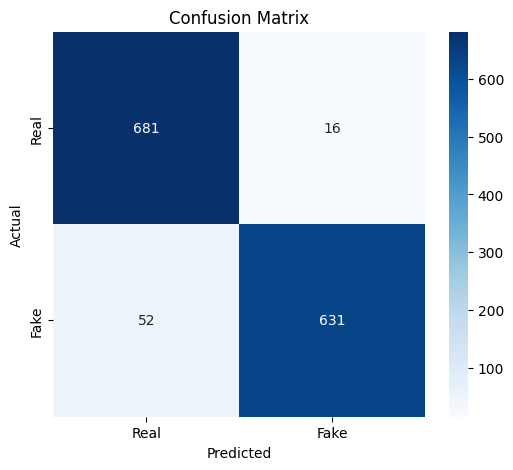

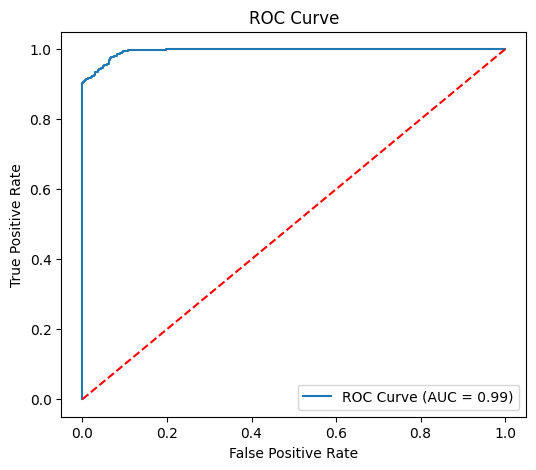

In [6]:

# Block 6: Model Evaluation & Visualization

loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0,1], [0,1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [7]:

# Block 7: Save Model

os.makedirs("outputs", exist_ok=True)
model.save("outputs/cnn_model_deepfake_optimized.h5")
print("✅ Model saved to outputs/cnn_model_deepfake_optimized.h5")


✅ Model saved to outputs/cnn_model_deepfake_optimized.h5


In [1]:
# ============================================================

# 9. Accuracy vs Loss Curves

# ============================================================

plt.figure(figsize=(12, 5))

# Accuracy

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

NameError: name 'plt' is not defined